In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.4.0


In [3]:
# MNIST 데이터세트 불러오기
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
print(train_X.shape, train_Y.shape)
train_X = train_X / 255.0
test_X = test_X / 255.0

latent_size = 64

(60000, 28, 28) (60000,)


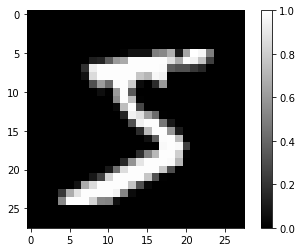

5


In [4]:
# MNIST 데이터세트 확인
plt.imshow(train_X[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()
print(train_Y[0])

In [9]:
train_X = train_X.reshape(-1, 28*28)
test_X = test_X.reshape(-1, 28*28)
print(train_X.shape, train_Y.shape)

# Functional API
input_img = tf.keras.Input(shape=(784,))
#encoder
encoder1 = tf.keras.layers.Dense(256, activation='relu')(input_img)
encoder2 = tf.keras.layers.Dense(128, activation='relu')(encoder1)
encoder3 = tf.keras.layers.Dense(latent_size, activation='relu')(encoder2)

# decoder
decoder1 = tf.keras.layers.Dense(128, activation='relu')(encoder3)
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
output_img = tf.keras.layers.Dense(784, activation='sigmoid')(decoder2)

# 오토인코더 모델 정의
autoencoder = tf.keras.Model(inputs=input_img, outputs=output_img)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_X, train_X, epochs=10, batch_size=256)

(60000, 784) (60000,)
Epoch 1/10
235/235 [==============================] - 2s 6ms/step - loss: 0.0876
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0263
Epoch 3/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0187
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0156
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0137
Epoch 6/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0126
Epoch 7/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0113
Epoch 8/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0105
Epoch 9/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0098
Epoch 10/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0093


In [10]:
# 인코더 모델 정의
encoder = tf.keras.Model(inputs=input_img, outputs=encoder3)
encoded_input = tf.keras.Input(shape=(latent_size,))

# 디코더 모델 정의
decoder_layer1 = autoencoder.layers[-3](encoded_input)
decoder_layer2 = autoencoder.layers[-2](decoder_layer1)
decoder_layer3 = autoencoder.layers[-1](decoder_layer2)
decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer3)
# decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer3(decoder_layer2(decoder_layer1(encoder_input))))

In [12]:
latent_train = encoder.predict(train_X)
latent_test = encoder.predict(test_X)

# 재구성 값
reconstructed_imgs = decoder.predict(latent_test)

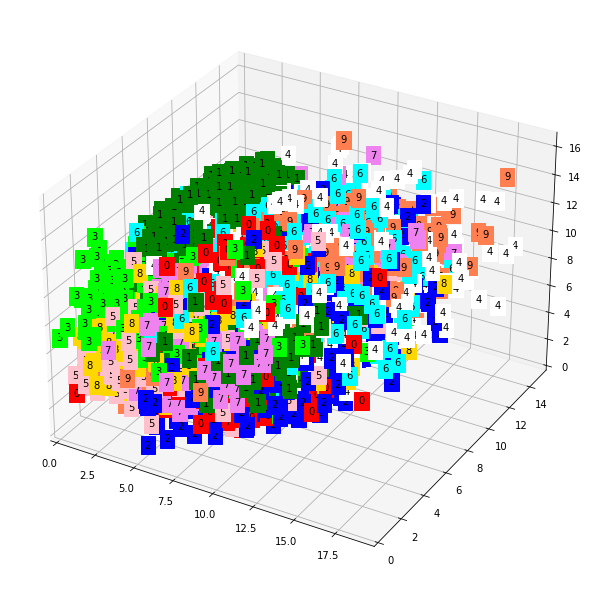

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from IPython.display import Image
from pylab import rcParams

rcParams['figure.figsize'] = 10, 8
fig = plt.figure(1)
ax = Axes3D(fig)

xs = latent_test[:, 0]
ys = latent_test[:, 1]
zs = latent_test[:, 2]

color=['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']

for x, y, z, label in zip(xs, ys, zs, test_Y):
    c = color[int(label)]
    ax.text(x, y, z, label, backgroundcolor=c)
    
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())

plt.show()

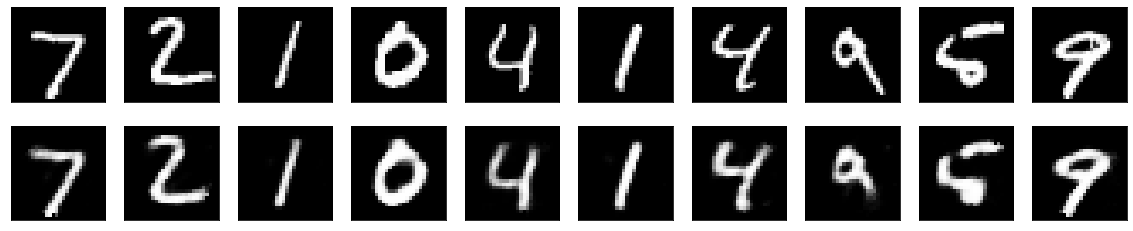

In [16]:
n =10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_X[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstructed image
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
# 원핫코딩
train_Y_onehot = tf.keras.utils.to_categorical(train_Y, num_classes=10)
test_Y_onehot = tf.keras.utils.to_categorical(test_Y, num_classes=10)

# Functional API
input_latent = tf.keras.Input(shape=(latent_size,))

# classifier
hidden = tf.keras.layers.Dense(32, activation='relu')(input_latent)
output_class = tf.keras.layers.Dense(10, activation='softmax')(hidden)

# 오토인코더 모델 정의
classifier = tf.keras.Model(inputs=input_latent, outputs=output_class)
classifier.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = classifier.fit(latent_train, train_Y_onehot, epochs=25, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping()])

Epoch 1/25
1407/1407 [==============================] - 2s 927us/step - loss: 1.9822 - accuracy: 0.5178 - val_loss: 0.4566 - val_accuracy: 0.8597
Epoch 2/25
1407/1407 [==============================] - 1s 851us/step - loss: 0.4403 - accuracy: 0.8686 - val_loss: 0.3667 - val_accuracy: 0.8936
Epoch 3/25
1407/1407 [==============================] - 1s 815us/step - loss: 0.3738 - accuracy: 0.8875 - val_loss: 0.3281 - val_accuracy: 0.9018
Epoch 4/25
1407/1407 [==============================] - 1s 811us/step - loss: 0.3486 - accuracy: 0.8961 - val_loss: 0.2966 - val_accuracy: 0.9101
Epoch 5/25
1407/1407 [==============================] - 1s 824us/step - loss: 0.3133 - accuracy: 0.9056 - val_loss: 0.2800 - val_accuracy: 0.9161
Epoch 6/25
1407/1407 [==============================] - 1s 882us/step - loss: 0.2870 - accuracy: 0.9103 - val_loss: 0.2645 - val_accuracy: 0.9195
Epoch 7/25
1407/1407 [==============================] - 1s 858us/step - loss: 0.2755 - accuracy: 0.9149 - val_loss: 0.2652 -

In [18]:
# 성능평가
classifier.evaluate(latent_test, test_Y_onehot, verbose=0)

[0.250071257352829, 0.92330002784729]